In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_profiling as pf
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from prettytable import PrettyTable


## Importing Data and Overview

In [54]:
data=pd.read_csv("german_credit_data.csv")

In [55]:
data.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car

### Background on Data

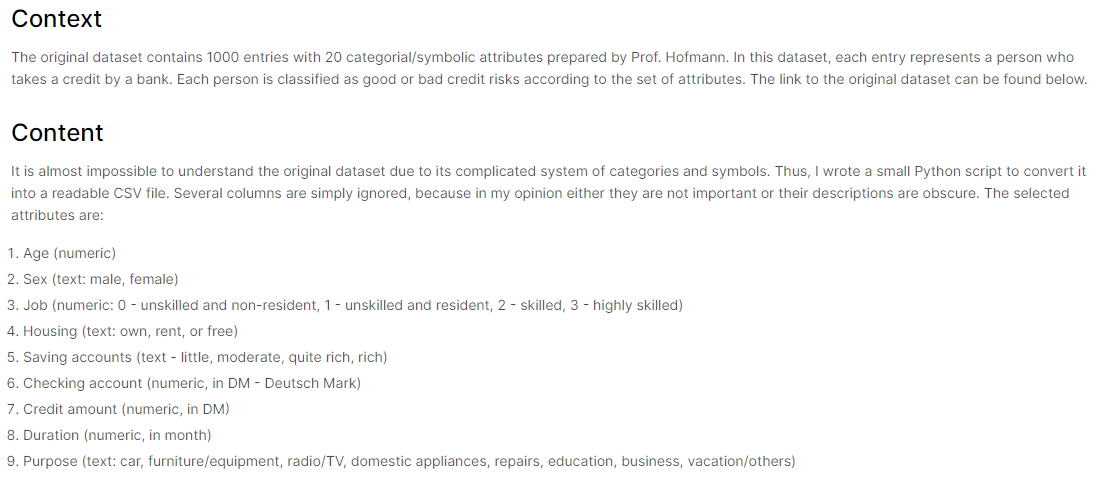

In [8]:
data=data.drop(data.columns[0], axis=1)

In [56]:
# Dimensions of dataset.
data.shape

(1000, 10)

In [57]:
# Type of each variable
data.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object

In [59]:
# Number of NA values in each column
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [60]:
# Number of Unique values in each column
data.nunique()

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
dtype: int64

In [65]:
# Function to make scatterplots
def scatters(data, h=None, pal=None):
    fig, (a, b, c) = plt.subplots(3,1, figsize=(8,14))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=a)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=b)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=c)
plt.tight_layout()

<Figure size 576x396 with 0 Axes>

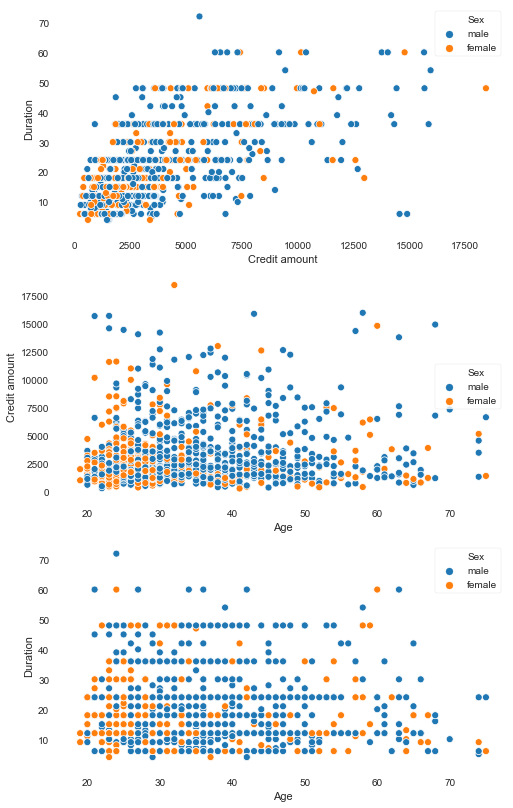

In [66]:
# Based on Sex
scatters(data, h="Sex")

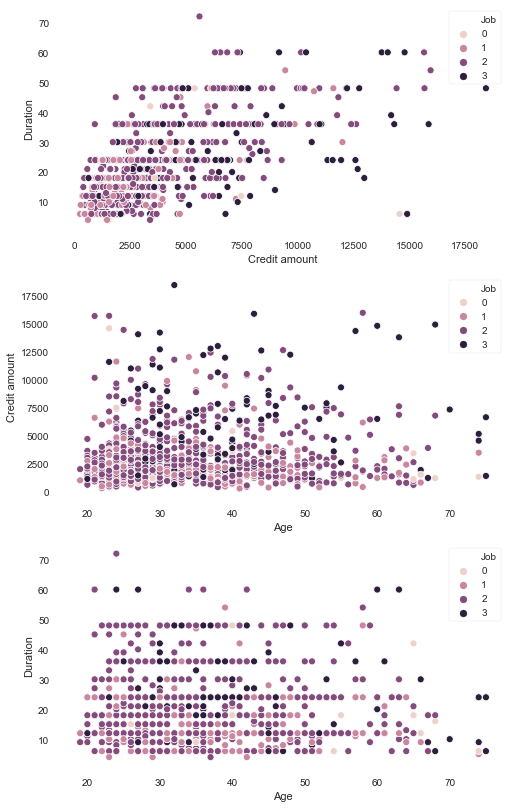

In [67]:
# Based on Job
scatters(data, h="Job")

### Correlation Heatmap

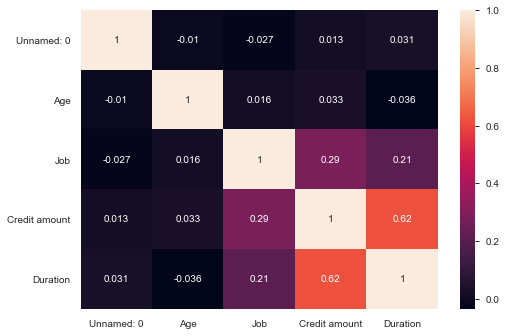

In [68]:

corrMatrix=data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Regression Plots to further look into correlations

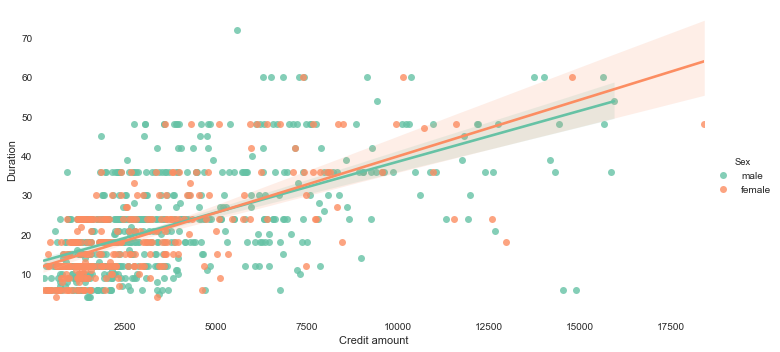

In [69]:
# Reggression Plot Between Credit Amount and Duration based on Sex
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set2", aspect=2)
plt.show()

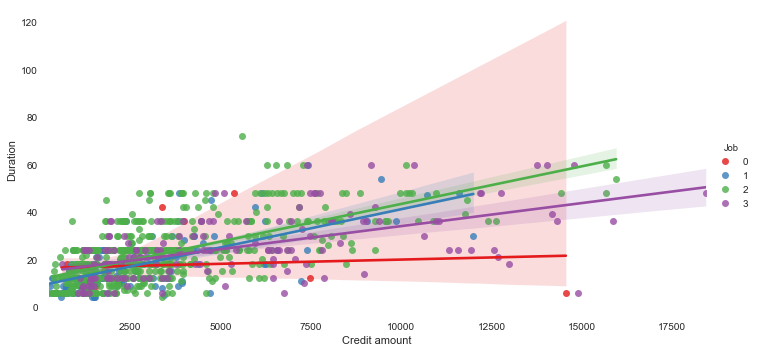

In [70]:
# Reggression Plot Based on Jobs
sns.lmplot(x="Credit amount",y="Duration", hue="Job", data=data, palette="Set1", aspect=2)
plt.show()


### Barplots to Look into Credits Issued

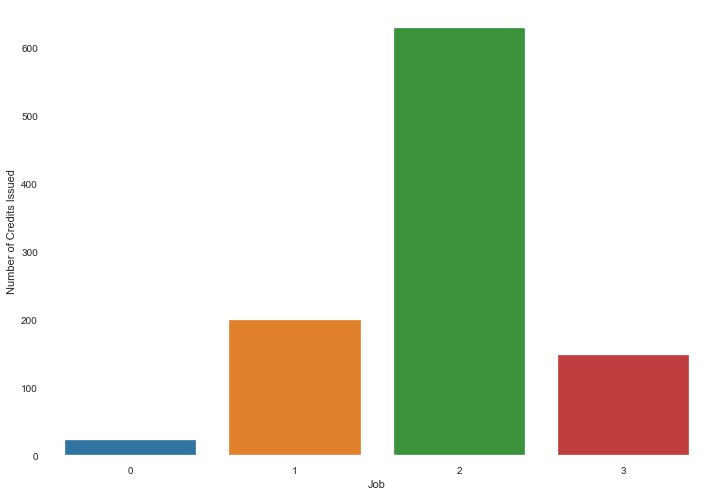

In [71]:
# Barplots to summarize overall
byjob = data.groupby("Job")["Age"].count().rename("Number").reset_index()
byjob.sort_values(by=["Number"], ascending=False, inplace=True)

plt.figure(figsize=(10,7))
bar1 = sns.barplot(x="Job",y="Number",data=byjob)
bar1.set_xticklabels(bar1.get_xticklabels())
plt.ylabel("Number of Credits Issued")
plt.tight_layout()

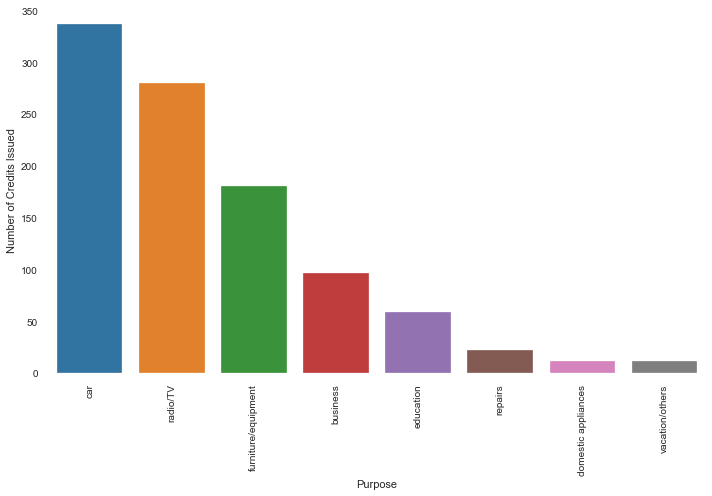

In [72]:
bypurpose = data.groupby("Purpose")["Age"].count().rename("Number").reset_index()
bypurpose.sort_values(by=["Number"], ascending=False, inplace=True)
plt.figure(figsize=(10,7))
bar2 = sns.barplot(x="Purpose",y="Number",data=bypurpose)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
plt.ylabel("Number of Credits Issued")
plt.tight_layout()

### Boxplot to look at Outliers and Overall Spread

In [73]:
# Function to make boxplots
def boxplt(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,7))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=90)
    fig.subplots_adjust(bottom=0.4)
    plt.tight_layout()

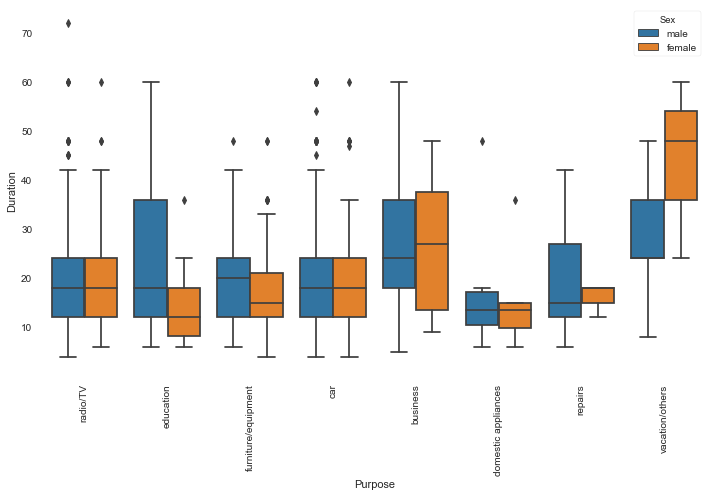

In [74]:
# Boxplots based on Duration and Purpose
boxplt("Purpose","Duration","Sex")


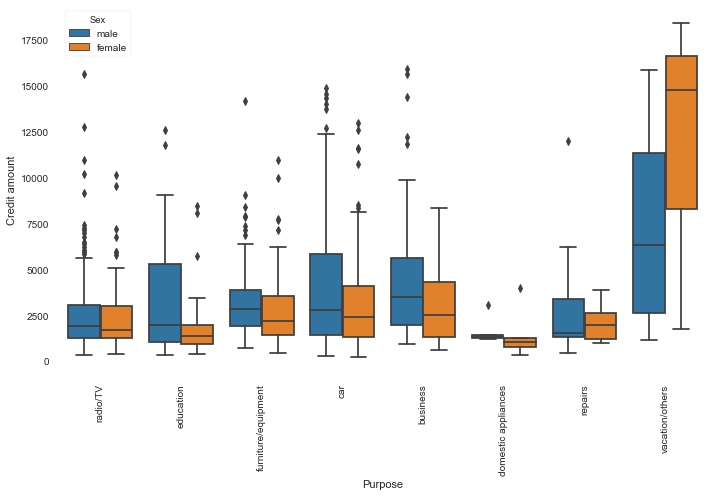

In [75]:
# Boxplots Based on Credit amount and Purpose
boxplt("Purpose","Credit amount","Sex")

### Data Profiling for Overall View

In [76]:
data.profile_report()

##### By looking at the above data report we can see that three variables which are Age, Credit Amount and Duration have a Right Skew.

### Log Transform Variables which are Right Skewed

In [77]:
def distributions(df): # This function is to plot histograms of variables that are right skewed
    fig, (a, b, c) = plt.subplots(3,1, figsize=(10,7))
    sns.distplot(df["Age"], ax=a,color="r")
    sns.distplot(df["Credit amount"], ax=b,color="g")
    sns.distplot(df["Duration"], ax=c,color="b")
    plt.tight_layout()

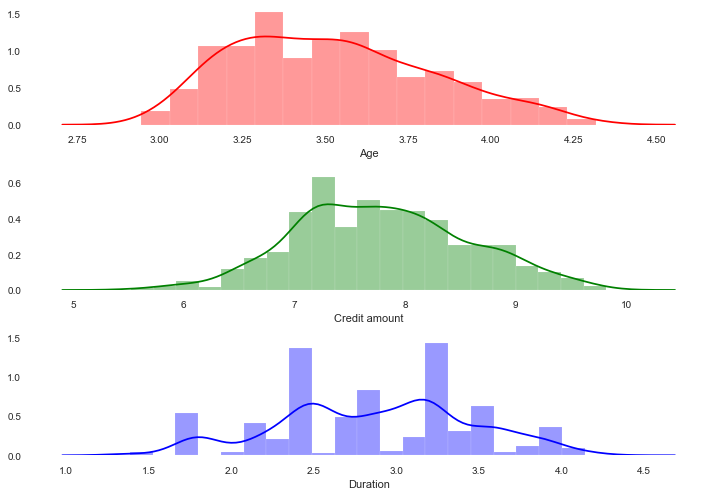

In [78]:
distributions(np.log(data[["Age","Credit amount","Duration"]]))

In [79]:
#Dataset containing Log of these three variables
data2=data[["Age","Credit amount","Duration"]]

data2_log=np.log(data2)

# Scale data
scale=StandardScaler()
data_sc=scale.fit_transform(data2_log)

### How Many Clusters To Seed

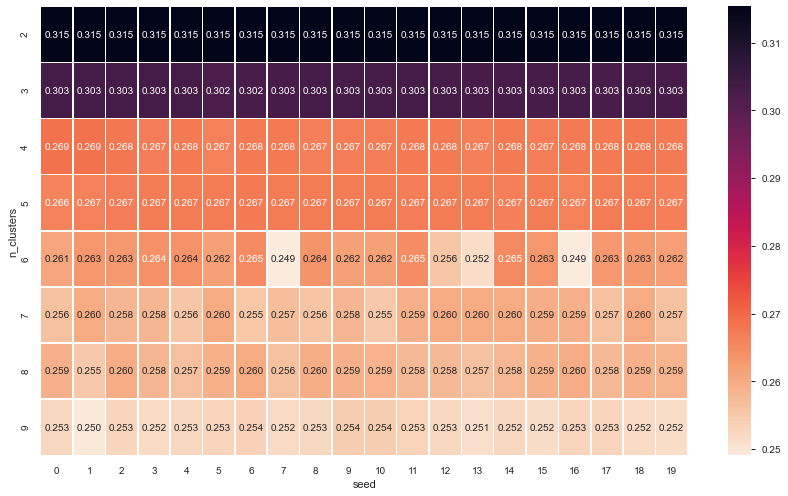

In [80]:
clusters_range = range(2,10)
random_range = range(0,20)
result=[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_lab = clusterer.fit_predict(data_sc)
        silhouette_avg = silhouette_score(data_sc, cluster_lab)
        result.append([c,r,silhouette_avg])

result = pd.DataFrame(result, columns=["n_clusters","seed","silhouette_score"])
pivot_result = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(12,7))
sns.heatmap(pivot_result, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

#### Ny looking at the heatmap above we can determine that two or three clusters will be ideal in this scenario.

## KMeans Clustering

In [81]:
kmean=KMeans(n_clusters=3, random_state=1).fit(data_sc)
labels=pd.DataFrame(kmean.labels_)
data_clustered=clustered=data2.assign(Cluster=labels)

### Show Clusters as Scatterplots

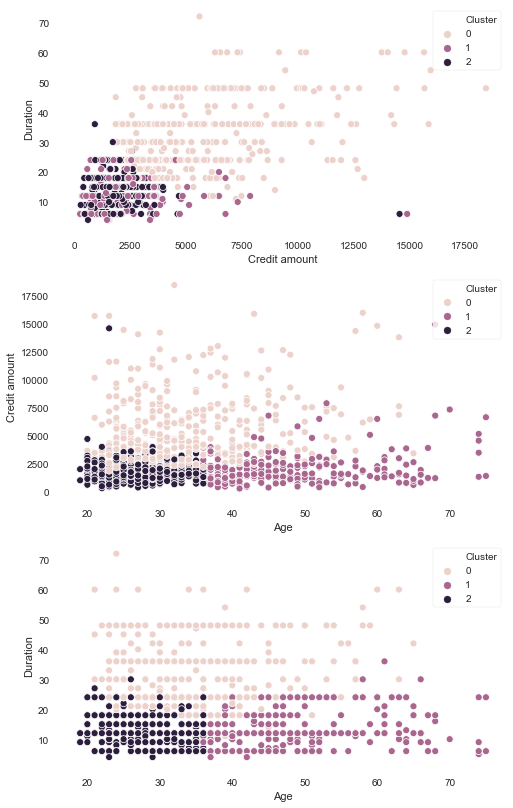

In [82]:
scatters(data_clustered,"Cluster")

## Clusters Divided in Groups

In [86]:
grouped_cluster=data_clustered.groupby(["Cluster"]).mean().round(2)
print(grouped_cluster)

           Age  Credit amount  Duration
Cluster                                
0        34.04        5665.38     32.22
1        48.69        1979.75     13.92
2        27.78        1732.20     14.25


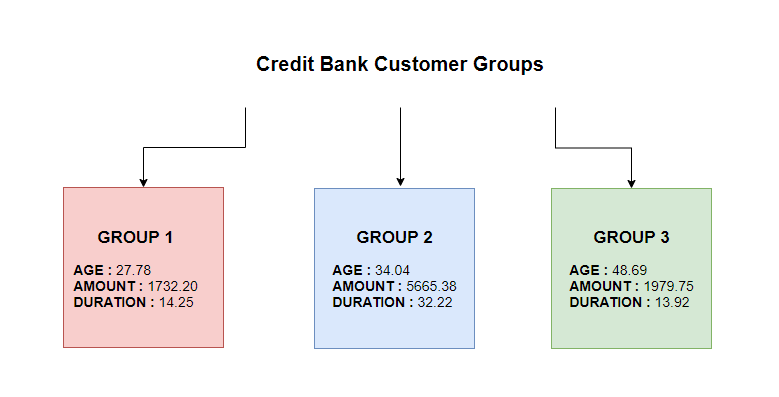